In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from influxdb import InfluxDBClient

# Data Exploration 

### Pull points with python client library and isolate the signal_value

In [3]:
client = InfluxDBClient(host='localhost', port=8086)
norm = client.query('SELECT "signal_value" FROM "norm_ekg"."autogen"."EKG" limit 8192')
norm_points = [p for p in norm.get_points()]
norm_df = pd.DataFrame(norm_points)
norm_df.head()

,signal_value,time
0,-4,2018-09-12T18:53:46Z
1,-4,2018-09-12T18:53:47Z
2,-5,2018-09-12T18:53:48Z
3,-2,2018-09-12T18:53:49Z
4,-2,2018-09-12T18:53:50Z


### Convert signal value to an array 

In [4]:
ekg_data = np.array(norm_df["signal_value"])
ekg_data[0:5]

array([-4, -4, -5, -2, -2])

In [5]:
print("signal_values[0]:\t", ekg_data[0])
print("signal_values[1]:\t", ekg_data[1])
print("signal_values.min:\t", ekg_data.min())
print("signal_values.max:\t", ekg_data.max())

signal_values[0]:	 -4
signal_values[1]:	 -4
signal_values.min:	 -99
signal_values.max:	 124


### Plot first 300 points to see what data looks like 

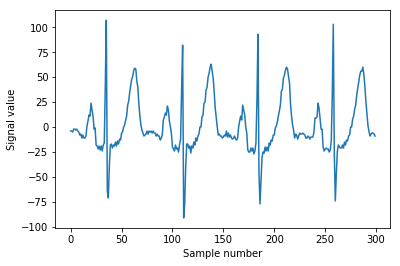

In [8]:
n_samples_to_plot = 300
plt.plot(ekg_data[0:n_samples_to_plot])
plt.xlabel("Sample number")
plt.ylabel("Signal value")
plt.show()

# Segmentation

In [9]:
segment_len = 32
slide_len = 2

segments = []
for start_pos in range(0, len(ekg_data), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original ekg_data
    segment = np.copy(ekg_data[start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

Produced 4081 waveform segments


In [10]:
def plot_waves(waves, step):
    """
    Plot a set of 9 waves from the given set, starting from the first one
    and increasing in index by 'step' for each subsequent graph
    """
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            axes.set_ylim([-100, 150])
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    # fix subplot sizes so that everything fits
    plt.tight_layout()
    plt.show()

### Plot the wave segments to see what they look like 

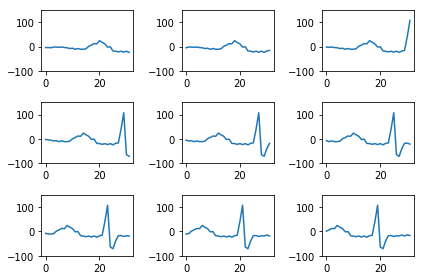

In [12]:
plot_waves(segments, step=1)

# Windowing

### We will multiply the segments by a window function to apply tapperign to each segment. Each segment will begin and end with a zero-value. This will allow us to seemlessly reconstruct a prediction by stitching together predicted segments that have matching beginning and end zero-values. 

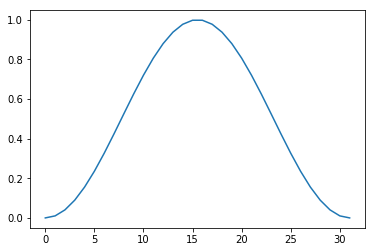

In [13]:
window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
plt.plot(window)
plt.show()

### Multiply (element-wise) our segments by the sin function

In [14]:
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)

### Take a look at our new segments

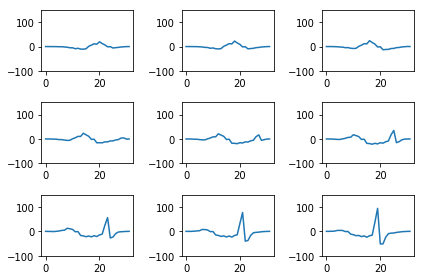

In [16]:
plot_waves(windowed_segments, step=1)

# Clustering

### Create 150 clusters

In [17]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=150)
clusterer.fit(windowed_segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=150, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### See what shapes/polynomials Kmeans "learned"

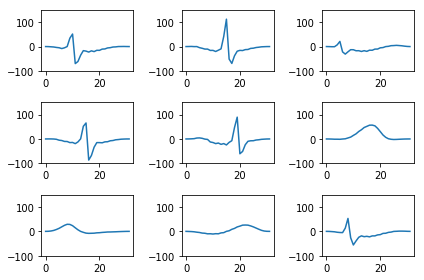

In [18]:
plot_waves(clusterer.cluster_centers_, step=15)

In [20]:
def sliding_chunker(data, window_len, slide_len):
    """ Segmentation """
    chunks = []
    for pos in range(0, len(data), slide_len):
        chunk = np.copy(data[int(pos):int(pos+window_len)])
        if len(chunk) != window_len:
            continue
        chunks.append(chunk)

    return chunks

In [21]:
slide_len = int(segment_len/2)
test_segments = sliding_chunker(
    ekg_data,
    window_len=segment_len,
    slide_len=slide_len
)
len(test_segments)

511

Maximum reconstruction error was 2.6


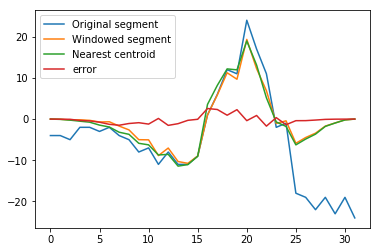

In [22]:
centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[0])
# remember, the clustering was set up using the windowed data
# so to find a match, we should also window our search key
windowed_segment = segment * window
# predict() returns a list of centres to cope with the possibility of multiple
# samples being passed
nearest_centroid_idx = clusterer.predict(windowed_segment.reshape(1,-1))[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])
error = nearest_centroid[0:32] - windowed_segment[0:32]
plt.figure()
plt.plot(segment, label="Original segment")
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.plot(error, label="error")
print("Maximum reconstruction error was %.1f" % error.max())
plt.legend()
plt.show()

### Find the error for 300 points on the normal data to determine a good threshold 

Maximum reconstruction error was 8.8
98th percentile of reconstruction error was 5.9


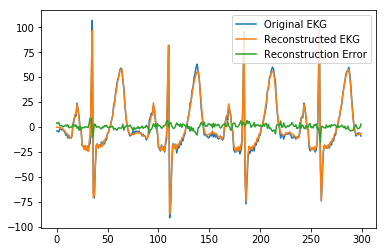

In [23]:
reconstruction = np.zeros(len(ekg_data))
slide_len = segment_len/2

for segment_n, segment in enumerate(test_segments):
    # don't modify the data in segments
    segment = np.copy(segment)
    segment = segment * window
    nearest_centroid_idx = clusterer.predict(segment.reshape(1,-1))[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = segment_n * slide_len
    reconstruction[int(pos):int(pos+segment_len)] += nearest_centroid

n_plot_samples = 300

error = reconstruction[0:n_plot_samples] - ekg_data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(ekg_data[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

# Anomaly Detection

In [27]:
client = InfluxDBClient(host='localhost', port=8086)
anomaly = client.query('SELECT "signal_value" FROM "anomaly_ekg"."autogen"."EKG" limit 8192')
anomaly_points = [p for p in anomaly.get_points()]
anomaly_df = pd.DataFrame(anomaly_points)
anomaly_df[210:215]

,signal_value,time
210,0,2018-09-12T18:57:16Z
211,0,2018-09-12T18:57:17Z
212,0,2018-09-12T18:57:18Z
213,0,2018-09-12T18:57:19Z
214,0,2018-09-12T18:57:20Z


In [28]:
ekg_data_anomalous = np.array(anomaly_df["signal_value"])
ekg_data_anomalous[210:215]

array([0, 0, 0, 0, 0])

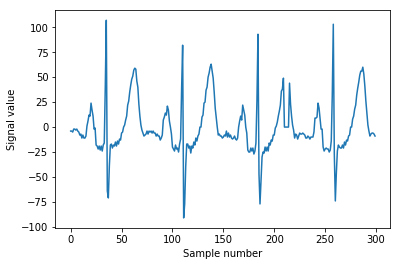

In [29]:
n_samples_to_plot = 300
plt.plot(ekg_data_anomalous[0:n_samples_to_plot])
plt.xlabel("Sample number")
plt.ylabel("Signal value")
plt.show()

In [603]:

start = datetime(2018, 9, 12, 18, 53, 45)
window_time = 33
slide_time = 16
threshold_error = 8.8


while True: 
    end = start + timedelta(seconds=window_time)
    query = 'SELECT "signal_value" FROM "anomaly_ekg"."autogen"."EKG" WHERE time > \'' + str(start) + '\' and time < \'' + str(end) + '\'' 
    client = InfluxDBClient(host='localhost', port=8086)
    anomaly_stream = client.query(query)
    anomaly_pnts = [p for p in anomaly_stream.get_points()]
    df_anomaly = pd.DataFrame(anomaly_pnts)
    anomalous = np.array(df_anomaly["signal_value"])
    
    windowed_segment = anomalous * window
    nearest_centroid_idx = clusterer.predict(windowed_segment.reshape(1,-1))[0]
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])

    error = nearest_centroid[0:n_plot_samples] - windowed_segment[0:n_plot_samples]
    max_error = error.max()
    
    write_time =  start + timedelta(seconds=slide_time)
    client.switch_database("error_ekg")
    json_body = [
        {
            "measurement": "ERROR",
            "tags": {
                "error": "max_error",
            },
            "time": write_time,
            "fields": {
                "max_error": max_error
            }
        }]
    client.write_points(json_body)
    print("QUERY:" + query)
    print("MAX ERROR:" + str(max_error))
    start = start + timedelta(seconds=slide_time) 
    time.sleep(1)    

QUERY:SELECT "signal_value" FROM "anomaly_ekg"."autogen"."EKG" WHERE time > '2018-09-12 18:53:45' and time < '2018-09-12 18:54:18'
MAX ERROR:4.852384840682989
QUERY:SELECT "signal_value" FROM "anomaly_ekg"."autogen"."EKG" WHERE time > '2018-09-12 18:54:01' and time < '2018-09-12 18:54:34'
MAX ERROR:4.592227252540116
QUERY:SELECT "signal_value" FROM "anomaly_ekg"."autogen"."EKG" WHERE time > '2018-09-12 18:54:17' and time < '2018-09-12 18:54:50'
MAX ERROR:1.5673825285708727
QUERY:SELECT "signal_value" FROM "anomaly_ekg"."autogen"."EKG" WHERE time > '2018-09-12 18:54:33' and time < '2018-09-12 18:55:06'
MAX ERROR:4.082755232121528
QUERY:SELECT "signal_value" FROM "anomaly_ekg"."autogen"."EKG" WHERE time > '2018-09-12 18:54:49' and time < '2018-09-12 18:55:22'
MAX ERROR:1.376459833140407
QUERY:SELECT "signal_value" FROM "anomaly_ekg"."autogen"."EKG" WHERE time > '2018-09-12 18:55:05' and time < '2018-09-12 18:55:38'
MAX ERROR:3.6043012951378692
QUERY:SELECT "signal_value" FROM "anomaly_ek

KeyboardInterrupt: 